In [1]:
%ls zippedData

bom.movie_gross.csv      rt.movie_info.tsv        tmdb.movies.csv.gz
bom.movie_gross.csv.gz   rt.movie_info.tsv.gz     tn.movie_budgets.csv
im.db                    rt.reviews.tsv           tn.movie_budgets.csv.gz
im.db 2                  rt.reviews.tsv.gz
im.db.zip                tmdb.movies.csv


In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
movies = pd.read_csv('zippedData//tmdb.movies.csv.gz')

In [5]:
movie_budgets = pd.read_csv('zippedData//tn.movie_budgets.csv.gz')

In [6]:
print(movies.columns, movie_budgets.columns)

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object') Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')


In [7]:
# Merging movie_budgets and movies with an inner join
masterdf = movie_budgets.merge(movies, how='inner', left_on='movie', right_on='title', suffixes=('_budgets', '_movies'))

In [8]:
masterdf.shape

(2385, 16)

In [9]:
masterdf['movie'].duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2380    False
2381    False
2382    False
2383    False
2384    False
Name: movie, Length: 2385, dtype: bool

In [10]:
conn = sqlite3.connect('zippedData/im.db')

In [11]:
# Merging the movie basics and movie rating table with left join
basics_and_ratings = pd.read_sql("""
SELECT *
FROM movie_basics
LEFT JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
    """, conn )

In [12]:
# Merging the newly merged basics/ratings dataset with the movie budget/movies dataset with an inner join
new_masterdf = masterdf.merge(basics_and_ratings, how='inner', left_on='movie', right_on='primary_title', suffixes=('_master','_database')).drop_duplicates(subset='movie')

In [13]:
new_masterdf.shape

(1789, 25)

In [14]:
new_masterdf.columns

Index(['id_budgets', 'release_date_budgets', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'Unnamed: 0', 'genre_ids',
       'id_movies', 'original_language', 'original_title_master', 'popularity',
       'release_date_movies', 'title', 'vote_average', 'vote_count',
       'movie_id', 'primary_title', 'original_title_database', 'start_year',
       'runtime_minutes', 'genres', 'movie_id', 'averagerating', 'numvotes'],
      dtype='object')

In [15]:
# Dropping columns with repeated information or information not relevant to analysis from the datasets
new_masterdf.drop(['id_movies', 'Unnamed: 0', 'original_title_database', 'movie_id', 'primary_title', 'title', \
                  'id_budgets', 'start_year', 'original_title_master'], axis=1, inplace=True)

In [16]:
new_masterdf['vote_count'].describe()

count    1789.00000
mean     1672.93907
std      2670.73022
min         1.00000
25%        79.00000
50%       620.00000
75%      2039.00000
max     22186.00000
Name: vote_count, dtype: float64

In [17]:
# For dataset that does not contain the bottom 25% of votes
new_masterdf[new_masterdf['vote_count'] > 79]

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279","[28, 12, 14, 878]",en,26.52600,2009-12-18,7.40000,18676,93.00000,Horror,6.10000,43.00000
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875","[12, 28, 14]",en,30.57900,2011-05-20,6.40000,8571,136.00000,"Action,Adventure,Fantasy",6.60000,447624.00000
2,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963","[28, 12, 878]",en,44.38300,2015-05-01,7.30000,13457,141.00000,"Action,Adventure,Sci-Fi",7.30000,665594.00000
3,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200","[12, 28, 14]",en,80.77300,2018-04-27,8.30000,13948,149.00000,"Action,Adventure,Sci-Fi",8.50000,670926.00000
4,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209","[28, 12, 14, 878]",en,34.95300,2017-11-17,6.20000,7510,120.00000,"Action,Adventure,Fantasy",6.50000,329135.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,"May 18, 2012",Indie Game: The Movie,"$100,000",$0,$0,[99],en,6.20200,2012-05-18,7.80000,259,103.00000,"Documentary,Drama",7.70000,19538.00000
4514,"Jul 25, 2014",Happy Christmas,"$70,000","$30,312","$30,312","[35, 18]",en,5.76700,2014-06-26,5.10000,95,109.00000,None,NaN,NaN
4516,"Dec 31, 2011",Absentia,"$70,000",$0,"$8,555","[9648, 27, 53]",en,10.35700,2011-03-03,5.90000,175,87.00000,"Drama,Horror,Mystery",5.80000,15507.00000
4522,"Nov 12, 2010",Tiny Furniture,"$50,000","$391,674","$424,149","[10749, 35, 18]",en,6.69500,2010-11-12,5.90000,82,98.00000,"Comedy,Drama,Romance",6.20000,13397.00000


In [18]:
# defining function to remove $ and ,
def remove_dollarsigncommas(data, column):
    data[column] = data[column].str.replace(',','')
    data[column] = data[column].str.replace('$','')
    return print('all done') ; print(data[column].head())

In [19]:
remove_dollarsigncommas(new_masterdf, 'production_budget')
remove_dollarsigncommas(new_masterdf, 'worldwide_gross')
remove_dollarsigncommas(new_masterdf, 'domestic_gross')

all done
all done
all done


/var/folders/v0/p588qkrd5kb8kdnf_3zrlbm80000gn/T/ipykernel_7736/3126015405.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[column] = data[column].str.replace('$','')


In [20]:
new_masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1789 entries, 0 to 4549
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release_date_budgets  1789 non-null   object 
 1   movie                 1789 non-null   object 
 2   production_budget     1789 non-null   object 
 3   domestic_gross        1789 non-null   object 
 4   worldwide_gross       1789 non-null   object 
 5   genre_ids             1789 non-null   object 
 6   original_language     1789 non-null   object 
 7   popularity            1789 non-null   float64
 8   release_date_movies   1789 non-null   object 
 9   vote_average          1789 non-null   float64
 10  vote_count            1789 non-null   int64  
 11  runtime_minutes       1739 non-null   float64
 12  genres                1778 non-null   object 
 13  averagerating         1714 non-null   float64
 14  numvotes              1714 non-null   float64
dtypes: float64(5), int64(

In [24]:
# cast the production_budget, domestic_gross and worldwide_gross as integers from objects
new_masterdf[['production_budget', 'domestic_gross', 'worldwide_gross']] = new_masterdf[['production_budget', 'domestic_gross', 'worldwide_gross']].applymap(lambda x: int(x))

In [23]:
new_masterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1789 entries, 0 to 4549
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release_date_budgets  1789 non-null   object 
 1   movie                 1789 non-null   object 
 2   production_budget     1789 non-null   int64  
 3   domestic_gross        1789 non-null   int64  
 4   worldwide_gross       1789 non-null   int64  
 5   genre_ids             1789 non-null   object 
 6   original_language     1789 non-null   object 
 7   popularity            1789 non-null   float64
 8   release_date_movies   1789 non-null   object 
 9   vote_average          1789 non-null   float64
 10  vote_count            1789 non-null   int64  
 11  runtime_minutes       1739 non-null   float64
 12  genres                1778 non-null   object 
 13  averagerating         1714 non-null   float64
 14  numvotes              1714 non-null   float64
dtypes: float64(5), int64(

In [27]:
# Singling and creating column for the release month
new_masterdf['release_month'] = new_masterdf['release_date_movies'].map(lambda x: x[5:7])

In [28]:
new_masterdf

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,release_month
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[28, 12, 14, 878]",en,26.52600,2009-12-18,7.40000,18676,93.00000,Horror,6.10000,43.00000,12
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[12, 28, 14]",en,30.57900,2011-05-20,6.40000,8571,136.00000,"Action,Adventure,Fantasy",6.60000,447624.00000,05
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[28, 12, 878]",en,44.38300,2015-05-01,7.30000,13457,141.00000,"Action,Adventure,Sci-Fi",7.30000,665594.00000,05
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[12, 28, 14]",en,80.77300,2018-04-27,8.30000,13948,149.00000,"Action,Adventure,Sci-Fi",8.50000,670926.00000,04
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[28, 12, 14, 878]",en,34.95300,2017-11-17,6.20000,7510,120.00000,"Action,Adventure,Fantasy",6.50000,329135.00000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541,"Sep 1, 2015",Exeter,25000,0,489792,"[53, 27]",en,5.93400,2015-03-26,4.70000,121,91.00000,"Horror,Mystery,Thriller",4.50000,5156.00000,03
4544,"Apr 21, 2015",Ten,25000,0,0,"[12, 27, 9648, 53]",en,1.57500,2014-03-28,5.40000,5,118.00000,Drama,5.50000,31.00000,03
4547,"Dec 31, 2014",Dry Spell,22000,0,0,"[35, 10749]",en,0.60000,2013-02-14,6.00000,1,90.00000,"Comedy,Romance",3.30000,120.00000,02
4548,"Jan 4, 2013",All Superheroes Must Die,20000,0,0,"[878, 53]",en,2.07800,2013-01-04,3.90000,19,78.00000,"Sci-Fi,Thriller",4.00000,1977.00000,01


In [29]:
# TMDB movie genre ID's and respective genre names
## Source: https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee

tmdb_movie_genreIDs = {'genres':[{'id':28,'name':'Action'},
    {'id':12,'name':'Adventure'},
    {'id':16,'name':'Animation'},
    {'id':35,'name':'Comedy'},
    {'id':80,'name':'Crime'},
    {'id':99,'name':'Documentary'},
    {'id':18,'name':'Drama'},
    {'id':10751,'name':'Family'},
    {'id':14,'name':'Fantasy'},
    {'id':36,'name':'History'},
    {'id':27,'name':'Horror'},
    {'id':10402,'name':'Music'},
    {'id':9648,'name':'Mystery'},
    {'id':10749,'name':'Romance'},
    {'id':878,'name':'Science Fiction'},
    {'id':10770,'name':'TV Movie'},
    {'id':53,'name':'Thriller'},
    {'id':10752,'name':'War'},
    {'id':37,'name':'Western'}]}

In [30]:
# Replace genre_ids numerics with genre names

new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('28', 'Action')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('12', 'Adventure')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('16', 'Animation')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('35', 'Comedy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('80', 'Crime')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('99', 'Documentary')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('18', 'Drama')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10751', 'Family')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('14', 'Fantasy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('36', 'History')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('27', 'Horror')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10402', 'Music')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('9648', 'Mystery')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10749', 'Romance')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('878', 'Science Fiction')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10770', 'TV Movie')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('53', 'Thriller')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10752', 'War')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('37', 'Western')

In [31]:
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].map(lambda x: x.lstrip('[').rstrip(']').split(','))

In [32]:
#reset index
new_masterdf.reset_index(inplace=True)

In [33]:
new_masterdf

,index,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,release_month
0,0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",en,26.52600,2009-12-18,7.40000,18676,93.00000,Horror,6.10000,43.00000,12
1,1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",en,30.57900,2011-05-20,6.40000,8571,136.00000,"Action,Adventure,Fantasy",6.60000,447624.00000,05
2,2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",en,44.38300,2015-05-01,7.30000,13457,141.00000,"Action,Adventure,Sci-Fi",7.30000,665594.00000,05
3,3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",en,80.77300,2018-04-27,8.30000,13948,149.00000,"Action,Adventure,Sci-Fi",8.50000,670926.00000,04
4,4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",en,34.95300,2017-11-17,6.20000,7510,120.00000,"Action,Adventure,Fantasy",6.50000,329135.00000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,4541,"Sep 1, 2015",Exeter,25000,0,489792,"[Thriller, Horror]",en,5.93400,2015-03-26,4.70000,121,91.00000,"Horror,Mystery,Thriller",4.50000,5156.00000,03
1785,4544,"Apr 21, 2015",Ten,25000,0,0,"[Adventure, Horror, Mystery, Thriller]",en,1.57500,2014-03-28,5.40000,5,118.00000,Drama,5.50000,31.00000,03
1786,4547,"Dec 31, 2014",Dry Spell,22000,0,0,"[Comedy, Romance]",en,0.60000,2013-02-14,6.00000,1,90.00000,"Comedy,Romance",3.30000,120.00000,02
1787,4548,"Jan 4, 2013",All Superheroes Must Die,20000,0,0,"[Science Fiction, Thriller]",en,2.07800,2013-01-04,3.90000,19,78.00000,"Sci-Fi,Thriller",4.00000,1977.00000,01


In [36]:
# Merging the newly merged genre breakdown dataset with the master dataset with an left join
final_df = new_masterdf.join(pd.DataFrame(new_masterdf.genre_ids.values.tolist()).add_prefix('genre_'), how='left', lsuffix='_votes')

# Reset the column labeled index
final_df.drop('index', axis=1, inplace=True)

# Find the amount of missing data from each column
final_df.isna().sum()/len(final_df)

release_date_budgets   0.00000
movie                  0.00000
production_budget      0.00000
domestic_gross         0.00000
worldwide_gross        0.00000
genre_ids              0.00000
original_language      0.00000
popularity             0.00000
release_date_movies    0.00000
vote_average           0.00000
vote_count             0.00000
runtime_minutes        0.02795
genres                 0.00615
averagerating          0.04192
numvotes               0.04192
release_month          0.00000
genre_0                0.00000
genre_1                0.23812
genre_2                0.55115
genre_3                0.84572
genre_4                0.96534
genre_5                0.99329
genre_6                0.99944
dtype: float64

In [37]:
final_df

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,release_date_movies,vote_average,...,averagerating,numvotes,release_month,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",en,26.52600,2009-12-18,7.40000,...,6.10000,43.00000,12,Action,Adventure,Fantasy,Science Fiction,None,None,None
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",en,30.57900,2011-05-20,6.40000,...,6.60000,447624.00000,05,Adventure,Action,Fantasy,None,None,None,None
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",en,44.38300,2015-05-01,7.30000,...,7.30000,665594.00000,05,Action,Adventure,Science Fiction,None,None,None,None
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",en,80.77300,2018-04-27,8.30000,...,8.50000,670926.00000,04,Adventure,Action,Fantasy,None,None,None,None
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",en,34.95300,2017-11-17,6.20000,...,6.50000,329135.00000,11,Action,Adventure,Fantasy,Science Fiction,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,"Sep 1, 2015",Exeter,25000,0,489792,"[Thriller, Horror]",en,5.93400,2015-03-26,4.70000,...,4.50000,5156.00000,03,Thriller,Horror,None,None,None,None,None
1785,"Apr 21, 2015",Ten,25000,0,0,"[Adventure, Horror, Mystery, Thriller]",en,1.57500,2014-03-28,5.40000,...,5.50000,31.00000,03,Adventure,Horror,Mystery,Thriller,None,None,None
1786,"Dec 31, 2014",Dry Spell,22000,0,0,"[Comedy, Romance]",en,0.60000,2013-02-14,6.00000,...,3.30000,120.00000,02,Comedy,Romance,None,None,None,None,None
1787,"Jan 4, 2013",All Superheroes Must Die,20000,0,0,"[Science Fiction, Thriller]",en,2.07800,2013-01-04,3.90000,...,4.00000,1977.00000,01,Science Fiction,Thriller,None,None,None,None,None


In [38]:
# Drop all genre breakdown columns except for primary and secondary genre
final_df.drop(['genre_6','genre_5','genre_4','genre_3' ], axis=1, inplace=True)

#Find the counts of unique values of the original_language
final_df['original_language'].value_counts()

en    1719
fr      17
es       9
hi       8
zh       6
ru       4
de       3
pl       2
ko       2
ja       2
ar       1
ur       1
fa       1
tr       1
id       1
lt       1
xx       1
nl       1
da       1
he       1
sv       1
th       1
tl       1
te       1
hu       1
el       1
et       1
Name: original_language, dtype: int64

In [39]:
# Drop the original_language column as majority of movies are in English
final_df.drop('original_language', axis=1, inplace=True)

In [41]:
# Get the descriptive statistics of the domestic_gross column
final_df['domestic_gross'].describe()

count        1789.00000
mean     49076159.82560
std      81452488.68974
min             0.00000
25%       1065429.00000
50%      20497844.00000
75%      58269151.00000
max     760507625.00000
Name: domestic_gross, dtype: float64

In [42]:
# Narrow dataset to movies that have domestic gross profits greater than the 25th quartile
final_df = final_df[final_df['domestic_gross'] > 1065429]
final_df

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,genres,averagerating,numvotes,release_month,genre_0,genre_1,genre_2
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",26.52600,2009-12-18,7.40000,18676,93.00000,Horror,6.10000,43.00000,12,Action,Adventure,Fantasy
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",30.57900,2011-05-20,6.40000,8571,136.00000,"Action,Adventure,Fantasy",6.60000,447624.00000,05,Adventure,Action,Fantasy
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",44.38300,2015-05-01,7.30000,13457,141.00000,"Action,Adventure,Sci-Fi",7.30000,665594.00000,05,Action,Adventure,Science Fiction
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",80.77300,2018-04-27,8.30000,13948,149.00000,"Action,Adventure,Sci-Fi",8.50000,670926.00000,04,Adventure,Action,Fantasy
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",34.95300,2017-11-17,6.20000,7510,120.00000,"Action,Adventure,Fantasy",6.50000,329135.00000,11,Action,Adventure,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,"Jun 19, 2015",The Overnight,200000,1109808,1165996,"[Mystery, Comedy]",6.57600,2015-06-19,6.00000,200,88.00000,None,7.50000,24.00000,06,Mystery,Comedy,None
1745,"Jul 22, 2011",Another Earth,175000,1321194,2102779,"[Drama, Science Fiction]",10.03000,2011-07-22,6.70000,853,92.00000,"Drama,Romance,Sci-Fi",7.00000,85839.00000,07,Drama,Science Fiction,None
1752,"Jun 15, 2012",Your Sister's Sister,120000,1597486,3090593,"[Drama, Comedy]",7.11500,2012-06-14,6.60000,192,90.00000,"Comedy,Drama",6.70000,24780.00000,06,Drama,Comedy,None
1753,"Jul 10, 2015",The Gallows,100000,22764410,41656474,"[Horror, Thriller]",9.16600,2015-07-10,4.80000,591,81.00000,"Horror,Mystery,Thriller",4.20000,17763.00000,07,Horror,Thriller,None


In [43]:
# Drop the genres column
final_df.drop('genres', axis=1, inplace=True)

/var/folders/v0/p588qkrd5kb8kdnf_3zrlbm80000gn/T/ipykernel_7736/2053096080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.drop('genres', axis=1, inplace=True)


In [44]:
final_df

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,averagerating,numvotes,release_month,genre_0,genre_1,genre_2
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",26.52600,2009-12-18,7.40000,18676,93.00000,6.10000,43.00000,12,Action,Adventure,Fantasy
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",30.57900,2011-05-20,6.40000,8571,136.00000,6.60000,447624.00000,05,Adventure,Action,Fantasy
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",44.38300,2015-05-01,7.30000,13457,141.00000,7.30000,665594.00000,05,Action,Adventure,Science Fiction
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",80.77300,2018-04-27,8.30000,13948,149.00000,8.50000,670926.00000,04,Adventure,Action,Fantasy
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",34.95300,2017-11-17,6.20000,7510,120.00000,6.50000,329135.00000,11,Action,Adventure,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,"Jun 19, 2015",The Overnight,200000,1109808,1165996,"[Mystery, Comedy]",6.57600,2015-06-19,6.00000,200,88.00000,7.50000,24.00000,06,Mystery,Comedy,None
1745,"Jul 22, 2011",Another Earth,175000,1321194,2102779,"[Drama, Science Fiction]",10.03000,2011-07-22,6.70000,853,92.00000,7.00000,85839.00000,07,Drama,Science Fiction,None
1752,"Jun 15, 2012",Your Sister's Sister,120000,1597486,3090593,"[Drama, Comedy]",7.11500,2012-06-14,6.60000,192,90.00000,6.70000,24780.00000,06,Drama,Comedy,None
1753,"Jul 10, 2015",The Gallows,100000,22764410,41656474,"[Horror, Thriller]",9.16600,2015-07-10,4.80000,591,81.00000,4.20000,17763.00000,07,Horror,Thriller,None


In [49]:
## For the rows where there are no genre ids
final_df[final_df['genre_0'] == '']

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,popularity,release_date_movies,vote_average,vote_count,runtime_minutes,averagerating,numvotes,release_month,genre_0,genre_1,genre_2
212,"Apr 18, 2014",Transcendence,100000000,23022309,103039258,[],0.60000,2012-06-09,5.50000,2,98.00000,6.10000,22.00000,06,,None,None
241,"Apr 21, 2017",The Promise,90000000,8224288,10551417,[],0.60000,2013-10-16,9.00000,1,NaN,NaN,NaN,10,,None,None
337,"Jan 14, 2005",Elektra,65000000,24409722,56824633,[],0.60000,2017-09-09,8.00000,1,NaN,6.10000,64.00000,09,,None,None
350,"Oct 15, 2010",Red,60000000,90380162,196439693,[],0.60000,2014-01-01,5.00000,1,NaN,5.80000,9.00000,01,,None,None
409,"Aug 17, 2018",Alpha,51000000,35851379,99624873,[],0.84000,2015-01-25,7.00000,1,116.00000,5.50000,102.00000,01,,None,None
461,"May 24, 2002",Insomnia,46000000,67263182,113622499,[],0.60000,2012-12-18,10.00000,1,NaN,NaN,NaN,12,,None,None
493,"Oct 2, 1992",Hero,42000000,19487173,66787173,[],0.60000,2014-04-17,9.00000,1,NaN,NaN,NaN,04,,None,None
540,"Aug 16, 2013",Paranoia,40000000,7388654,16340767,[],0.60000,2011-06-07,4.50000,2,106.00000,5.70000,33149.00000,06,,None,None
697,"Sep 20, 2002",Trapped,30000000,6916869,6916869,[],0.65500,2012-04-01,5.80000,2,NaN,NaN,NaN,04,,None,None
779,"Nov 6, 2009",The Box,25000000,15051977,34356760,[],0.84000,2018-03-04,8.00000,1,89.00000,6.30000,51.00000,03,,None,None


In [46]:
# Average for dataset based on the Primary Genre
genre_budget_mean = final_df.groupby('genre_0').mean()
genre_budget_mean

,production_budget,domestic_gross,worldwide_gross,popularity,vote_average,vote_count,runtime_minutes,averagerating,numvotes
genre_0,,,,,,,,,
,33680555.55556,33575113.66667,59689841.05556,0.62972,5.98889,1.61111,87.25000,5.88333,13296.16667
Action,89901660.15625,104249344.48047,291213125.12500,16.88186,6.23359,3629.17188,112.47619,6.38600,201969.27600
Adventure,113538750.00000,122444950.02500,353204092.06250,18.81652,6.41500,4056.07500,111.73750,6.51667,193649.46154
Animation,91714285.71429,121912634.02041,343892169.75510,14.45047,6.64694,2653.85714,94.53191,6.71489,120144.74468
Comedy,28672222.22222,47016442.74486,87265313.99177,10.13087,6.20247,1195.48971,102.40664,6.18755,83330.00858
Crime,34392156.86275,40860806.11765,89152549.29412,14.61653,6.56471,2167.68627,113.44000,6.67600,147930.28000
Documentary,29208333.33333,41738422.70833,87158770.16667,3.15342,6.69583,59.33333,90.39130,6.77391,18551.43478
Drama,25720996.89441,37018063.06832,77286220.07143,10.16984,6.68354,1530.69565,111.62300,6.71851,102733.30195
Family,56305263.15789,113090691.68421,301816252.84211,12.14084,6.45263,2265.05263,97.38889,6.36111,70700.72222


In [65]:
wwgross_budget_ratio = genre_budget_mean['worldwide_gross'] / genre_budget_mean['production_budget']
wwgross_budget_ratio.sort_values(ascending=False)[:10]

genre_0
Family            5.36036
Horror            4.57002
TV Movie          4.44766
Romance           4.00503
History           3.98162
Animation         3.74960
Science Fiction   3.66412
Western           3.58381
Mystery           3.27693
Thriller          3.24337
dtype: float64

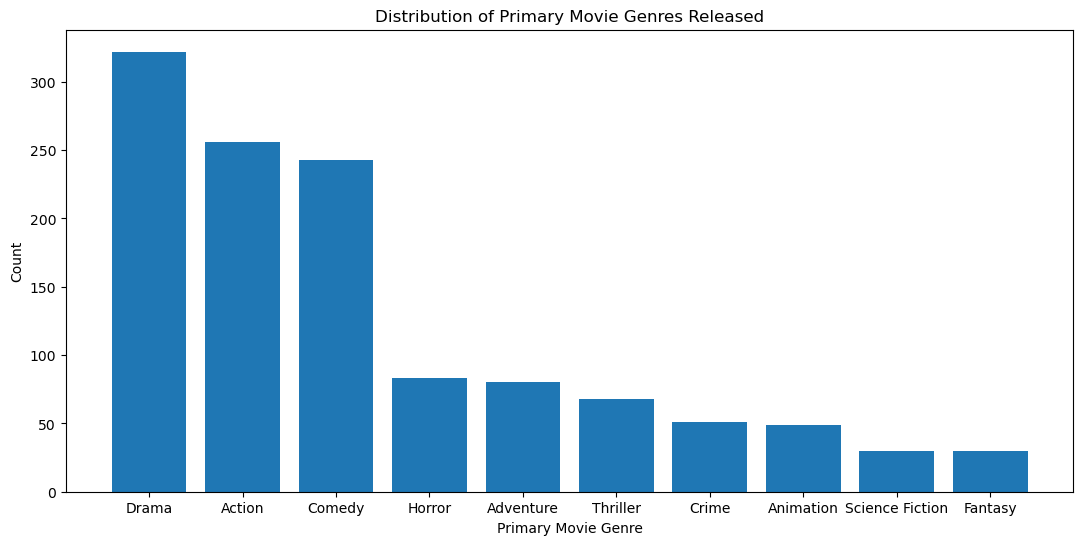

In [76]:
# Set up plots
fig, (ax) = plt.subplots(figsize=(13, 6))

# Create variable for easier reuse
genre_counts = final_df['genre_0'].value_counts()[:10]

# Plot bar chart 
ax.bar(genre_counts.index, genre_counts.values)

# Customize appearance
ax.set_xlabel('Primary Movie Genre');
ax.set_ylabel('Count')
ax.set_title('Distribution of Primary Movie Genres Released');

In [55]:
# Top 10 Genres with highest production budget
top_prod_budget = genre_budget_mean.sort_values(by='production_budget', ascending=False)[:10]

#Isolating the production budget column
top_prod_budget = top_prod_budget[['production_budget']]
top_prod_budget

,production_budget
genre_0,
Adventure,113538750.00000
Animation,91714285.71429
Action,89901660.15625
Science Fiction,83373333.33333
Fantasy,82603333.33333
Western,75500000.00000
War,68388888.88889
Family,56305263.15789
TV Movie,50000000.00000


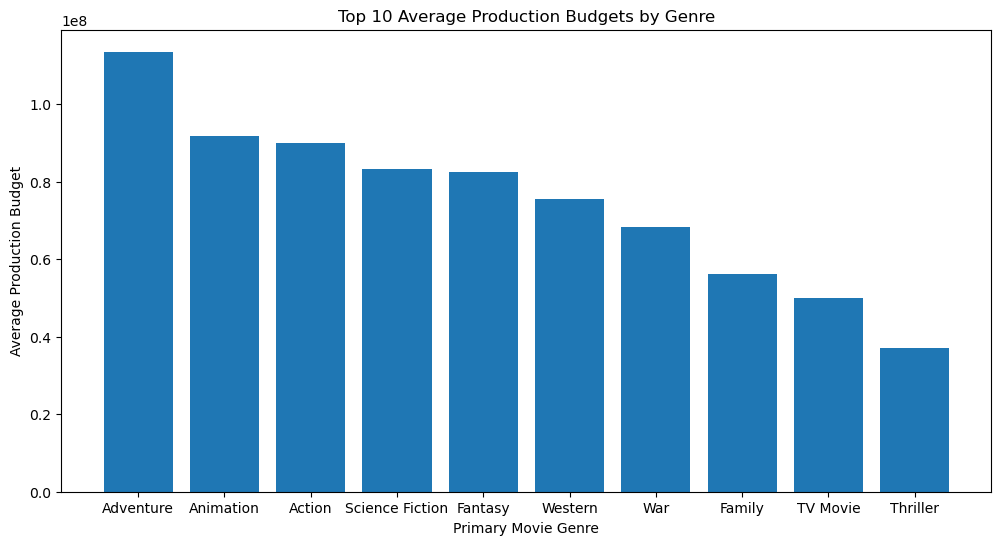

In [82]:
# Set up plots
fig, (ax) = plt.subplots(figsize=(12, 6))

# Plot bar chart 
ax.bar(top_prod_budget.index, top_prod_budget['production_budget'])

# Customize appearance
ax.set_xlabel('Primary Movie Genre');
ax.set_ylabel('Average Production Budget')
ax.set_title('Top 10 Average Production Budgets by Genre');

In [67]:
# Top 10 Genres with highest domestic gross gross profit
top_dgross = genre_budget_mean.sort_values(by='domestic_gross', ascending=False)[:10]

#Isolating the domestic gross profit column
top_dgross = top_dgross[['domestic_gross']]
top_dgross

,domestic_gross
genre_0,
Adventure,122444950.02500
Animation,121912634.02041
Science Fiction,116410724.20000
Family,113090691.68421
Action,104249344.48047
War,95272384.66667
Western,93033941.50000
TV Movie,91742160.00000
Fantasy,80323731.06667


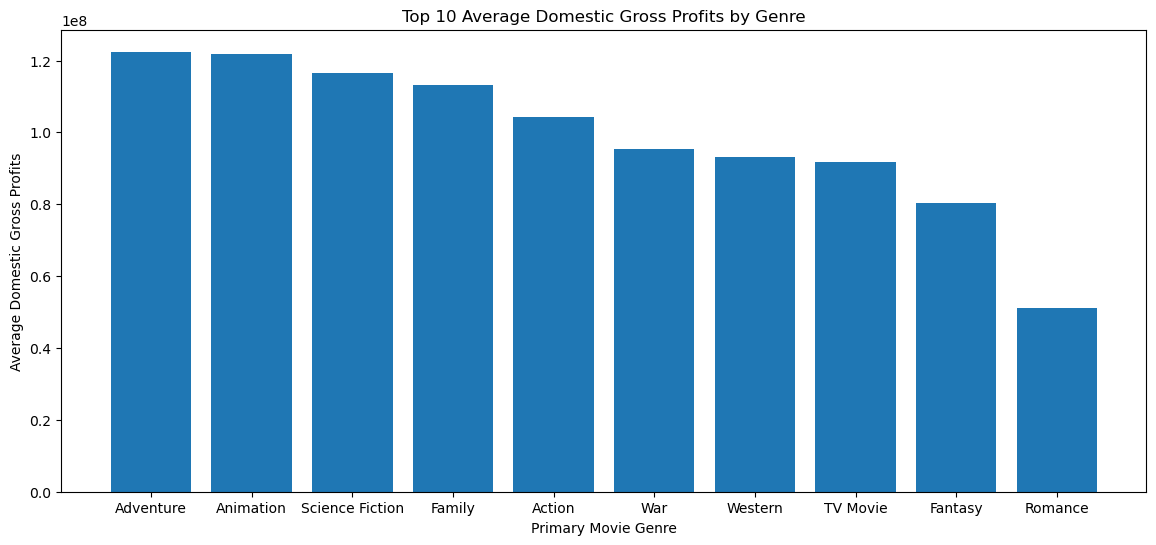

In [71]:
# Set up plots
fig, (ax) = plt.subplots(figsize=(14, 6))

# Plot bar chart 
ax.bar(top_dgross.index, top_dgross['domestic_gross'])

# Customize appearance
ax.set_xlabel('Primary Movie Genre');
ax.set_ylabel('Average Domestic Gross Profits')
ax.set_title('Top 10 Average Domestic Gross Profits by Genre');

In [58]:
# Top 10 Genres with highest worldwide gross profit
top_wwgross = genre_budget_mean.sort_values(by='worldwide_gross', ascending=False)[:10]

#Isolating the orldwide gross profit column
top_wwgross = top_wwgross[['worldwide_gross']]
top_wwgross

,worldwide_gross
genre_0,
Adventure,353204092.06250
Animation,343892169.75510
Science Fiction,305489621.20000
Family,301816252.84211
Action,291213125.12500
Western,270577936.50000
TV Movie,222383055.00000
Fantasy,212856275.93333
War,187710354.55556


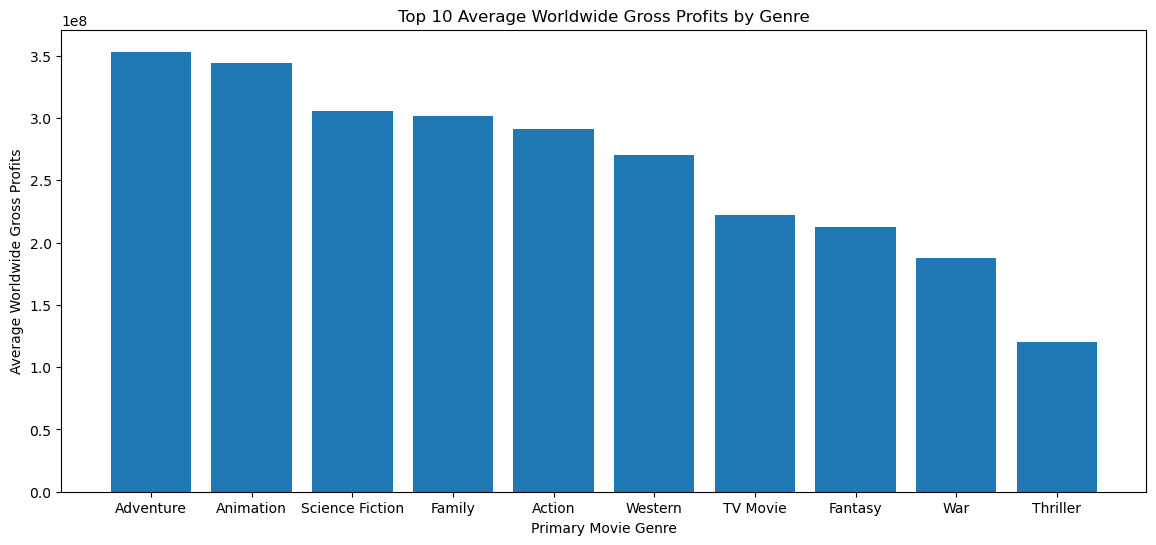

In [69]:
# Set up plots
fig, (ax) = plt.subplots(figsize=(14, 6))

# Plot bar chart 
ax.bar(top_wwgross.index, top_wwgross['worldwide_gross'])

# Customize appearance
ax.set_xlabel('Primary Movie Genre');
ax.set_ylabel('Average Worldwide Gross Profits')
ax.set_title('Top 10 Average Worldwide Gross Profits by Genre');

In [37]:
final_df

,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,release_date_movies,vote_average,...,averagerating,numvotes,release_month,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",en,26.52600,2009-12-18,7.40000,...,6.10000,43.00000,12,Action,Adventure,Fantasy,Science Fiction,None,None,None
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",en,30.57900,2011-05-20,6.40000,...,6.60000,447624.00000,05,Adventure,Action,Fantasy,None,None,None,None
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",en,44.38300,2015-05-01,7.30000,...,7.30000,665594.00000,05,Action,Adventure,Science Fiction,None,None,None,None
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",en,80.77300,2018-04-27,8.30000,...,8.50000,670926.00000,04,Adventure,Action,Fantasy,None,None,None,None
4,"Nov 17, 2017",Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",en,34.95300,2017-11-17,6.20000,...,6.50000,329135.00000,11,Action,Adventure,Fantasy,Science Fiction,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,"Sep 1, 2015",Exeter,25000,0,489792,"[Thriller, Horror]",en,5.93400,2015-03-26,4.70000,...,4.50000,5156.00000,03,Thriller,Horror,None,None,None,None,None
1785,"Apr 21, 2015",Ten,25000,0,0,"[Adventure, Horror, Mystery, Thriller]",en,1.57500,2014-03-28,5.40000,...,5.50000,31.00000,03,Adventure,Horror,Mystery,Thriller,None,None,None
1786,"Dec 31, 2014",Dry Spell,22000,0,0,"[Comedy, Romance]",en,0.60000,2013-02-14,6.00000,...,3.30000,120.00000,02,Comedy,Romance,None,None,None,None,None
1787,"Jan 4, 2013",All Superheroes Must Die,20000,0,0,"[Science Fiction, Thriller]",en,2.07800,2013-01-04,3.90000,...,4.00000,1977.00000,01,Science Fiction,Thriller,None,None,None,None,None
